In [1]:
# Install quantum libs
!pip install -q qiskit qiskit-machine-learning pennylane pennylane-qiskit torch qiskit-aer qiskit-algorithms



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.0/797.0 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Classical ML
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, auc
)

# TensorFlow Autoencoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Qiskit
from qiskit_aer import Aer
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# PennyLane
import pennylane as qml

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)


In [4]:
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

BASE_PATH = "/content/drive/MyDrive"
DATA_DIR = BASE_PATH  # Corrected: files are directly in MyDrive, not in a 'datasets' subfolder

def load_csv(file_name, base_path=DATA_DIR):
    path = os.path.join(base_path, file_name)
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    df = pd.read_csv(path)
    print(f"Loaded {file_name}: shape={df.shape}")
    return df

df_train = load_csv("Training.csv")
df_test = load_csv("part2.csv")

Mounted at /content/drive
Loaded Training.csv: shape=(176222, 31)
Loaded part2.csv: shape=(94936, 31)


In [5]:
# =========================================
# NEW DATA PREP: Training.csv + Test part
# =========================================

import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# --------------------------
# 1. Basic shapes and counts
# --------------------------

print("=== Dataset Shapes ===")
print(f"Training (Train): {df_train.shape}")
print(f"Test (Test2): {df_test.shape}")

print("\n=== Column Names ===")
print(df_train.columns.tolist())

# --------------------------
# 2. Class distribution
# --------------------------

def class_info(name, df):
    print(f"\n=== Class distribution: {name} ===")
    counts = df["Class"].value_counts()
    print(counts)
    print("Fraud percentage:", round(counts[1] / len(df) * 100, 4), "%")

class_info("Training (Train)", df_train)
class_info("Testing (Test2)", df_test)

# 1) Use the already loaded merged training set (Training.csv)
df_train_big = df_train.copy()
# Drop rows with NaN in 'Class' from df_train_big
df_train_big.dropna(subset=['Class'], inplace=True)

# 2) Use the already loaded test set (part2.csv)
df_test = df_test.copy()
# Drop rows with NaN in 'Class' from df_test
df_test.dropna(subset=['Class'], inplace=True)

# 3) Combine for shared scaling + indexing
df_combined = pd.concat([df_train_big, df_test], ignore_index=True)

X = df_combined.drop(columns=["Class"])
y_true = df_combined["Class"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4) Define index slices
n_train = len(df_train_big)
n_test = len(df_test)

idx_train = slice(0, n_train)                 # Train_big (Training.csv)
idx_test  = slice(n_train, n_train + n_test)  # Test (Part2 only)

print("Train_big shape:", df_train_big.shape)
print("Test (Part2) shape:", df_test.shape)
print("Combined X shape:", X_scaled.shape)
print("y_true shape:", y_true.shape)

=== Dataset Shapes ===
Training (Train): (176222, 31)
Test (Test2): (94936, 31)

=== Column Names ===
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

=== Class distribution: Training (Train) ===
Class
0.0    175893
1.0       328
Name: count, dtype: int64
Fraud percentage: 0.1861 %

=== Class distribution: Testing (Test2) ===
Class
0    94783
1      153
Name: count, dtype: int64
Fraud percentage: 0.1612 %
Train_big shape: (176221, 31)
Test (Part2) shape: (94936, 31)
Combined X shape: (271157, 30)
y_true shape: (271157,)


=== Dataset Shapes ===
Training (df_train): (176222, 31)
Test (df_test): (94936, 31)
Combined (df_combined): (271157, 31)

=== Column Names ===
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

=== Class distribution: Training (df_train) ===
Class
0.0    175893
1.0       328
Name: count, dtype: int64
Fraud percentage: 0.1861 %

=== Class distribution: Testing (df_test) ===
Class
0    94783
1      153
Name: count, dtype: int64
Fraud percentage: 0.1612 %

=== Class distribution: Combined (df_combined) ===
Class
0.0    270676
1.0       481
Name: count, dtype: int64
Fraud percentage: 0.1774 %

=== Missing Values (All Data) ===
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0

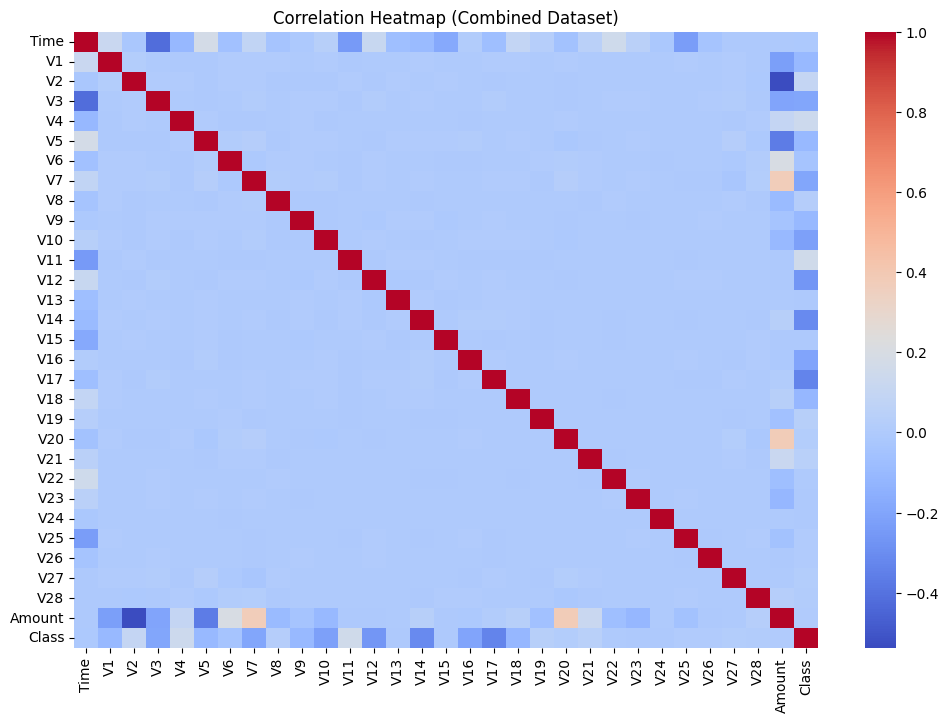

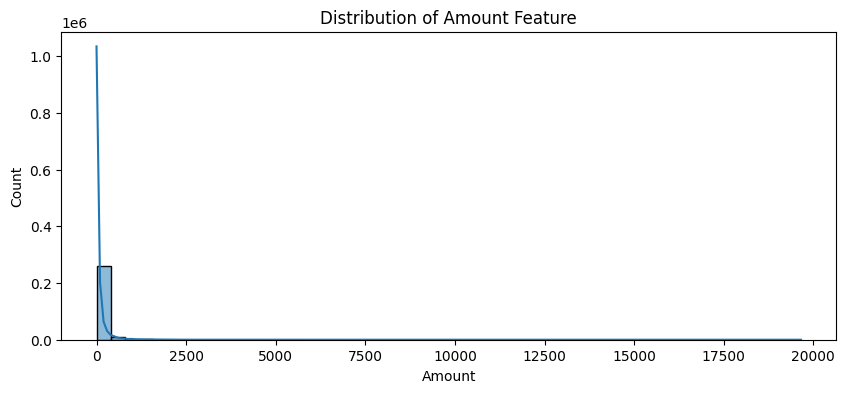

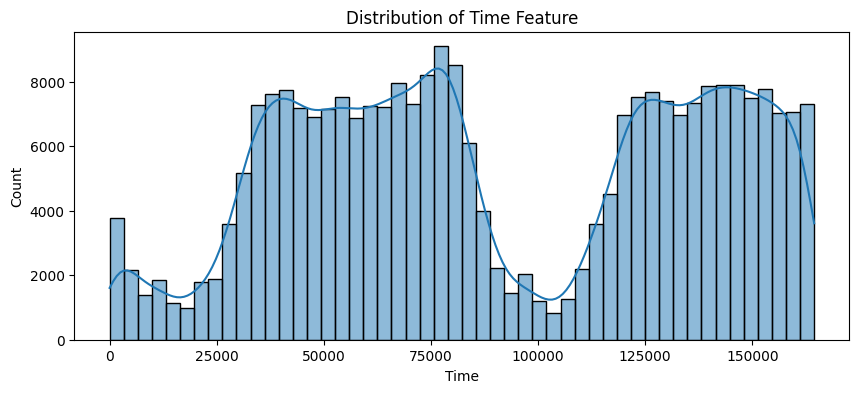


=== Data inspection completed ===


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 1. Basic shapes and counts
# --------------------------

print("=== Dataset Shapes ===")
print(f"Training (df_train): {df_train.shape}")
print(f"Test (df_test): {df_test.shape}")
print(f"Combined (df_combined): {df_combined.shape}")

print("\n=== Column Names ===")
print(df_train.columns.tolist())

# --------------------------
# 2. Class distribution
# --------------------------

def class_info(name, df):
    print(f"\n=== Class distribution: {name} ===")
    counts = df["Class"].value_counts()
    print(counts)
    print("Fraud percentage:", round(counts[1] / len(df) * 100, 4), "%")

class_info("Training (df_train)", df_train)
class_info("Testing (df_test)", df_test)
class_info("Combined (df_combined)", df_combined)

# The data preparation (concatenation, scaling, indexing) was done in the previous cell.
# We will use the existing df_combined, X_scaled, y_true, idx_train, idx_test.

# --------------------------
# 3. Missing values
# --------------------------
print("\n=== Missing Values (All Data) ===")
print(df_combined.isnull().sum()) # Using already combined dataframe

# --------------------------
# 4. Duplicate rows
# --------------------------
duplicates = df_combined.duplicated().sum()
print(f"\n=== Number of Duplicate Rows: {duplicates} ===")

# --------------------------
# 5. Descriptive statistics
# --------------------------
print("\n=== Descriptive Statistics (First 10 columns) ===")
print(df_combined.describe().iloc[:, :10])

# --------------------------
# 6. Data types
# --------------------------
print("\n=== Data Types ===")
print(df_combined.dtypes)

# --------------------------
# 7. Correlation heatmap (optional)
# --------------------------

plt.figure(figsize=(12, 8))
sns.heatmap(df_combined.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Combined Dataset)")
plt.show()

# --------------------------
# 8. Feature distribution example
# --------------------------
plt.figure(figsize=(10, 4))
sns.histplot(df_combined["Amount"], bins=50, kde=True)
plt.title("Distribution of Amount Feature")
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(df_combined["Time"], bins=50, kde=True)
plt.title("Distribution of Time Feature")
plt.show()

print("\n=== Data inspection completed ===")

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_input (InputLayer)           │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 4)              │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstruction (Dense)          │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,418 (32.88 KB)

 Trainable params: 8,418 (32.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.9154 - val_loss: 0.7080 - learning_rate: 0.0010
Epoch 2/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.7697 - val_loss: 0.6328 - learning_rate: 0.0010
Epoch 3/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.7110 - val_loss: 0.5997 - learning_rate: 0.0010
Epoch 4/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.6840 - val_loss: 0.5757 - learning_rate: 0.0010
Epoch 5/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6609 - val_loss: 0.5519 - learning_rate: 0.0010
Epoch 6/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6426 - val_loss: 0.5338 - learning_rate: 0.0010
Epoch 7/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.6264 - val_loss: 0.5264 - learning_rate: 0.0010
Epoch 8/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6166 - val_loss: 0.5186 - learning_rate: 0.0010
Epoch 9/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6109 - val_loss: 0.5126 - learning_rate: 0.0010
E

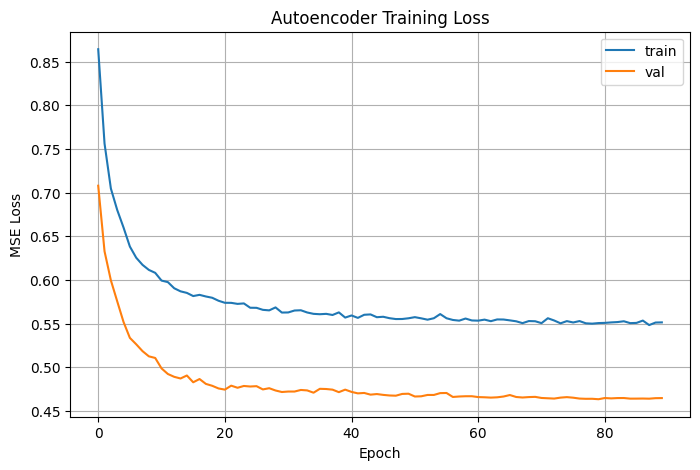

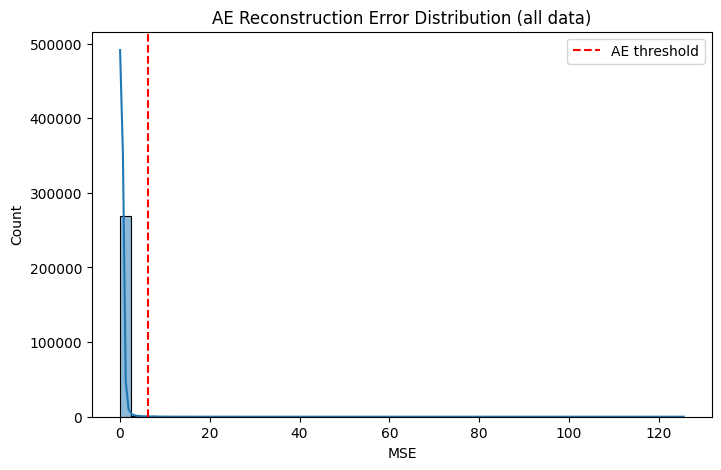

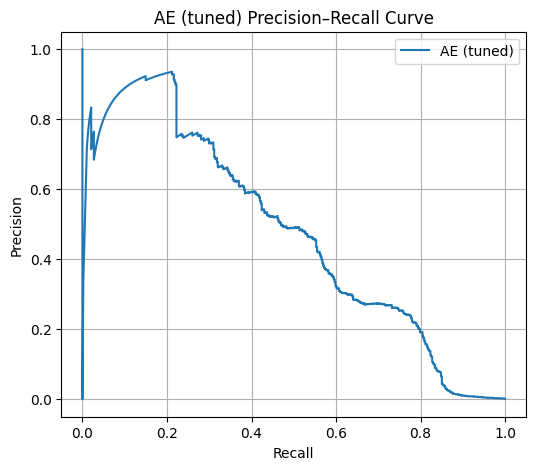

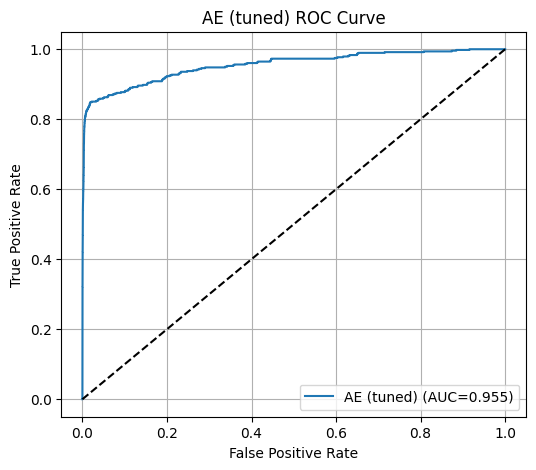

Bottleneck shape: (271157, 4)


In [8]:
# ============================
# Cell 3: Autoencoder (AE)
# ============================

input_dim = X_scaled.shape[1]

inp = Input(shape=(input_dim,), name="ae_input")

# Encoder
x = Dense(64, activation="relu")(inp)
x = Dropout(0.2)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.2)(x)

latent = Dense(4, activation="relu", name="latent")(x)  # bottleneck (4)

# Decoder
x = Dense(32, activation="relu")(latent)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)

out = Dense(input_dim, activation="linear", name="reconstruction")(x)

autoencoder = Model(inputs=inp, outputs=out, name="autoencoder")
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse"
)

autoencoder.summary()

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-5
)

# ---- Train AE on NORMAL samples from TRAIN only ----
y_train = y_true[idx_train]
X_train_all = X_scaled[idx_train]

normal_mask_train = (y_train == 0)
X_train_ae = X_train_all[normal_mask_train]  # only normals
X_eval_ae = X_scaled                          # for scoring all

history = autoencoder.fit(
    X_train_ae, X_train_ae,
    epochs=100,
    batch_size=256,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    shuffle=True,
    verbose=1
)

# ---- Reconstruction error on ALL data ----
reconstructed = autoencoder.predict(X_eval_ae, verbose=0)
ae_mse = np.mean((X_eval_ae - reconstructed)**2, axis=1)

# ---- Threshold tuning on TRAIN only ----
scores_train_ae = ae_mse[idx_train]
labels_train_ae = y_true[idx_train]

percentiles = np.linspace(90, 99.9, 50)
best_f1 = -1
best_p = None
best_thr = None
best_prec = None
best_rec = None

for p in percentiles:
    thr = np.percentile(scores_train_ae, p)
    preds = (scores_train_ae > thr).astype(int)
    prec = precision_score(labels_train_ae, preds, zero_division=0)
    rec  = recall_score(labels_train_ae, preds, zero_division=0)
    f1   = f1_score(labels_train_ae, preds, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_p = p
        best_thr = thr
        best_prec = prec
        best_rec = rec

print(f"\n[AE threshold tuning (Train_big only)]")
print(f"Best percentile: {best_p:.2f}")
print(f"Best threshold:  {best_thr:.4f}")
print(f"Precision:       {best_prec:.4f}")
print(f"Recall:          {best_rec:.4f}")
print(f"F1-score:        {best_f1:.4f}")

ae_thresh = best_thr
y_pred_ae_all = (ae_mse > ae_thresh).astype(int)

print(f"\nAE MSE threshold (tuned): {ae_thresh:.4f}")
print(f"Total AE anomalies: {(y_pred_ae_all == 1).sum()} / {len(y_pred_ae_all)}")

# ---- Metrics per split ----
print("\n=== AE (tuned) - Train_big ===")
_ = evaluate_model("AE (tuned) - Train_big",
                   y_true[idx_train], y_pred_ae_all[idx_train])

print("\n=== AE (tuned) - Test ===")
_ = evaluate_model("AE (tuned) - Test",
                   y_true[idx_test], y_pred_ae_all[idx_test])

# ---- Plots ----
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(8,5))
sns.histplot(ae_mse, bins=50, kde=True)
plt.axvline(ae_thresh, color="red", linestyle="--", label="AE threshold")
plt.title("AE Reconstruction Error Distribution (all data)")
plt.xlabel("MSE"); plt.ylabel("Count")
plt.legend(); plt.show()

plot_curves("AE (tuned)", y_true, ae_mse)

# ---- Bottleneck for downstream models ----
encoder_model = Model(
    inputs=autoencoder.input,
    outputs=autoencoder.get_layer("latent").output
)
X_bottleneck = encoder_model.predict(X_scaled, verbose=0)
print("Bottleneck shape:", X_bottleneck.shape)


In [9]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score

# ----------------------------
# 1) Build train/test splits
# ----------------------------
Xb_train = X_bottleneck[idx_train]
Xb_test  = X_bottleneck[idx_test]
y_train  = y_true[idx_train]
y_test   = y_true[idx_test]

# Normal-only mask on TRAIN_BIG
train_normal_mask = (y_train == 0)

# ----------------------------
# 2) Fit Isolation Forest on NORMALS ONLY (Train_big)
# ----------------------------
iso = IsolationForest(
    n_estimators=600,          # more trees = stabler scores
    max_samples=min(50000, Xb_train[train_normal_mask].shape[0]),  # cap for speed
    contamination="auto",      # don't force anomaly rate
    max_features=1.0,
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)

iso.fit(Xb_train[train_normal_mask])

# ----------------------------
# 3) Score ALL samples (train + test)
# decision_function: higher = more normal; invert so higher = more anomalous
# ----------------------------
if_score_train = -iso.decision_function(Xb_train)
if_score_test  = -iso.decision_function(Xb_test)

# Concatenate back to full-length array (align with y_true indexing)
iso_scores = np.empty_like(y_true, dtype=float)
iso_scores[idx_train] = if_score_train
iso_scores[idx_test]  = if_score_test

# ----------------------------
# 4) Threshold tuning on TRAIN_BIG ONLY (consistent real-world setup)
# ----------------------------
scores_train_if = iso_scores[idx_train]
labels_train_if = y_train

percentiles = np.linspace(90, 99.9, 60)
best = {"f1": -1, "p": None, "thr": None, "prec": None, "rec": None}

for p in percentiles:
    thr = np.percentile(scores_train_if, p)
    pred = (scores_train_if > thr).astype(int)

    prec = precision_score(labels_train_if, pred, zero_division=0)
    rec  = recall_score(labels_train_if, pred, zero_division=0)
    f1   = f1_score(labels_train_if, pred, zero_division=0)

    if f1 > best["f1"]:
        best.update({"f1": f1, "p": p, "thr": thr, "prec": prec, "rec": rec})

print("\n[IF threshold tuning (Train_big only)]")
print(f"Best percentile: {best['p']:.2f}")
print(f"Best threshold:  {best['thr']:.4f}")
print(f"Precision:       {best['prec']:.4f}")
print(f"Recall:          {best['rec']:.4f}")
print(f"F1-score:        {best['f1']:.4f}")

if_thresh = best["thr"]
y_pred_if_train = (if_score_train > if_thresh).astype(int)
y_pred_if_test  = (if_score_test  > if_thresh).astype(int)

print(f"\nIF anomalies (Train_big): {y_pred_if_train.sum()} / {len(y_pred_if_train)}")
print(f"IF anomalies (Test):      {y_pred_if_test.sum()} / {len(y_pred_if_test)}")

# Metrics per split
print("\n=== IF (tuned) - Train_big ===")
evaluate_model("IF (tuned) - Train_big", y_train, y_pred_if_train)

print("\n=== IF (tuned) - Test ===")
evaluate_model("IF (tuned) - Test", y_test, y_pred_if_test)

# Normalized IF score for ensembles
if_norm = normalize_scores(iso_scores)



[IF threshold tuning (Train_big only)]
Best percentile: 90.00
Best threshold:  -0.1043
Precision:       0.0064
Recall:          0.3415
F1-score:        0.0125

IF anomalies (Train_big): 17622 / 176221
IF anomalies (Test):      9167 / 94936

=== IF (tuned) - Train_big ===

=== IF (tuned) - Train_big ===
Precision: 0.0064
Recall:    0.3415
F1-score:  0.0125
ROC-AUC:   0.6210

Confusion matrix:
[[158383  17510]
 [   216    112]]

Classification report:
              precision    recall  f1-score   support

         0.0     0.9986    0.9005    0.9470    175893
         1.0     0.0064    0.3415    0.0125       328

    accuracy                         0.8994    176221
   macro avg     0.5025    0.6210    0.4797    176221
weighted avg     0.9968    0.8994    0.9453    176221


=== IF (tuned) - Test ===

=== IF (tuned) - Test ===
Precision: 0.0067
Recall:    0.3987
F1-score:  0.0131
ROC-AUC:   0.6513

Confusion matrix:
[[85677  9106]
 [   92    61]]

Classification report:
              prec

In [14]:
# ============================================================
# SOFT-GATED PIPELINE: AE + IF (main) + VQC (uncertain only)
# Works with 2-part split: Train_big + Test
# Requires already computed:
#   - ae_mse (N,)
#   - iso_scores (N,)
#   - X_bottleneck (N, latent_dim)
#   - y_all (N,)  OR (y_train, y_test + idx_train/idx_test)
#   - idx_train, idx_test slices
#   - evaluate_model(), normalize_scores()
# ============================================================

import numpy as np

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector


# ----------------------------
# 0) Labels and splits (2-part)
# ----------------------------
# If you already have y_true for full combined, use it:
# y_all = y_true.astype(np.int32)

# If you have separate y_train/y_test, rebuild y_all:
y_all = np.concatenate([y_train, y_test]).astype(np.int32)

# idx_train / idx_test must match your concatenation order
# Example:
# idx_train = slice(0, len(y_train))
# idx_test  = slice(len(y_train), len(y_train)+len(y_test))

# ----------------------------
# 1) Build AE+IF normalized scores
# ----------------------------
ae_norm = normalize_scores(ae_mse)
if_norm = normalize_scores(iso_scores)

# Weighted main score (start with these, tune later if needed)
w_ae, w_if = 0.70, 0.30
main_score = w_ae * ae_norm + w_if * if_norm

# ----------------------------
# 2) Tune threshold on TRAIN_BIG only (F1 search over percentiles)
# ----------------------------
scores_train = main_score[idx_train]
labels_train = y_all[idx_train]

percentiles = np.linspace(90, 99.9, 50)
best = {"f1": -1, "p": None, "thr": None, "prec": None, "rec": None}

for p in percentiles:
    thr = np.percentile(scores_train, p)
    preds = (scores_train > thr).astype(int)
    prec = precision_score(labels_train, preds, zero_division=0)
    rec  = recall_score(labels_train, preds, zero_division=0)
    f1   = f1_score(labels_train, preds, zero_division=0)
    if f1 > best["f1"]:
        best.update({"f1": f1, "p": p, "thr": thr, "prec": prec, "rec": rec})

main_thr = best["thr"]

print("\n[AE+IF Main Score tuning - Train_big only]")
print(f"Best percentile: {best['p']:.2f}")
print(f"Best threshold:  {main_thr:.4f}")
print(f"Precision:       {best['prec']:.4f}")
print(f"Recall:          {best['rec']:.4f}")
print(f"F1-score:        {best['f1']:.4f}")

# Main predictions (before VQC override)
y_pred_main_all = (main_score > main_thr).astype(int)

# ----------------------------
# 3) Define uncertainty band (soft gate)
# ----------------------------
# band_width controls how many samples get routed to VQC.
# Smaller = fewer routed, faster, more \u201cspecialist VQC\u201d.
band_width = 0.10

low = max(0.0, main_thr - band_width)
high = min(1.0, main_thr + band_width)

uncertain_mask_all = (main_score >= low) & (main_score <= high)

n_uncertain = uncertain_mask_all.sum()
print(f"\nSoft-gated: samples in uncertainty band: {n_uncertain} / {len(main_score)}")

# ----------------------------
# 4) Prepare quantum angles from AE latent (2 qubits => 2 angles)
# ----------------------------
# Use bottleneck only (keeps VQC \u201cunsupervised+quantum\u201d clean)
pca_2 = PCA(n_components=2, random_state=42)
latent_2 = pca_2.fit_transform(X_bottleneck)

# scale to [-pi, pi] for angle embedding
min_v = latent_2.min(axis=0)
max_v = latent_2.max(axis=0)
X_angles = ((latent_2 - min_v) / (max_v - min_v + 1e-12)) * (2*np.pi) - np.pi

# ----------------------------
# 5) Train VQC only on UNCERTAIN TRAIN_BIG samples
# ----------------------------
uncertain_train_mask = uncertain_mask_all.copy()
uncertain_train_mask[:] = False
uncertain_train_mask[idx_train] = uncertain_mask_all[idx_train]

train_uncertain_idx = np.where(uncertain_train_mask)[0]
# ---------- NEW: ensure enough frauds for VQC training ----------
y_unc = y_all[train_uncertain_idx]
n_fraud_unc = int((y_unc == 1).sum())

min_frauds_needed = 50  # target for VQC training stability

if n_fraud_unc < min_frauds_needed:
    # Pull extra frauds from Train_big closest to main_thr
    train_idx_arr = np.arange(idx_train.start, idx_train.stop)
    fraud_train_idx = train_idx_arr[y_all[idx_train] == 1]

    # sort frauds by closeness to main threshold (hard/uncertain frauds)
    close_order = np.argsort(np.abs(main_score[fraud_train_idx] - main_thr))
    extra_frauds = fraud_train_idx[close_order[: (min_frauds_needed - n_fraud_unc)]]

    train_uncertain_idx = np.unique(np.concatenate([train_uncertain_idx, extra_frauds]))

# Also cap normals to keep runtime sane (balance-ish)
y_unc = y_all[train_uncertain_idx]
fraud_idx = train_uncertain_idx[y_unc == 1]
norm_idx  = train_uncertain_idx[y_unc == 0]

rng = np.random.default_rng(42)
n_normals_keep = min(len(norm_idx), max(500, 6 * len(fraud_idx)))  # 6x frauds
if len(norm_idx) > n_normals_keep:
    norm_idx = rng.choice(norm_idx, size=n_normals_keep, replace=False)

train_uncertain_idx = np.concatenate([fraud_idx, norm_idx])
rng.shuffle(train_uncertain_idx)

print("VQC train uncertain subset:", len(train_uncertain_idx),
      "| frauds:", (y_all[train_uncertain_idx]==1).sum(),
      "| normals:", (y_all[train_uncertain_idx]==0).sum())

# If band too small and gives too few frauds, widen band_width a bit.
X_u = X_angles[train_uncertain_idx]
y_u = y_all[train_uncertain_idx].astype(np.float32)

print(f"Uncertain samples routed to VQC in Train_big: {len(train_uncertain_idx)}")

# Safety: ensure both classes exist in subset
if (y_u.sum() == 0) or (y_u.sum() == len(y_u)):
    print("\n\u26a0\ufe0f VQC training subset has only one class. Increase band_width or sample strategy.")
else:
    # Train/val split (stratified)
    X_train_q, X_val_q, y_train_q, y_val_q = train_test_split(
        X_u, y_u,
        test_size=0.2,
        stratify=y_u,
        random_state=42
    )

    X_train_t = torch.tensor(X_train_q, dtype=torch.float32)
    y_train_t = torch.tensor(y_train_q, dtype=torch.float32).view(-1, 1)
    X_val_t   = torch.tensor(X_val_q, dtype=torch.float32)
    y_val_t   = torch.tensor(y_val_q, dtype=torch.float32).view(-1, 1)

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
    val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=128, shuffle=False)

    # ---- VQC circuit (2 qubits, small but expressive) ----
    n_qubits = 2
    feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=1)
    ansatz = TwoLocal(
        n_qubits,
        rotation_blocks=["ry", "rz"],
        entanglement_blocks="cx",
        reps=2
    )
    circuit = feature_map.compose(ansatz)

    estimator = Estimator()
    observable = SparsePauliOp("Z" * n_qubits)

    qnn = EstimatorQNN(
        circuit=circuit,
        estimator=estimator,
        observables=[observable],
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
    )

    qnn_torch = TorchConnector(qnn)

    class VQCClassifier(nn.Module):
        def __init__(self, qmodule):
            super().__init__()
            self.q = qmodule

        def forward(self, x):
            q_out = self.q(x)
            if q_out.dim() == 1:
                q_out = q_out.view(-1, 1)
            p = (q_out + 1.0) / 2.0
            p = torch.clamp(p, 1e-6, 1.0 - 1e-6)
            logits = torch.log(p / (1.0 - p))
            return logits

    vqc_model = VQCClassifier(qnn_torch)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(vqc_model.parameters(), lr=1e-3)

    # ---- Train ----
    num_epochs = 6
    for epoch in range(num_epochs):
        vqc_model.train()
        tr_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = vqc_model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            tr_loss += loss.item() * xb.size(0)
        tr_loss /= len(train_loader.dataset)

        vqc_model.eval()
        va_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                logits = vqc_model(xb)
                loss = criterion(logits, yb)
                va_loss += loss.item() * xb.size(0)
        va_loss /= len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs} - train_loss={tr_loss:.4f} - val_loss={va_loss:.4f}")

    # ----------------------------
    # Compute VQC scores for the entire dataset
    # ----------------------------
    vqc_model.eval()
    with torch.no_grad():
        X_all_t_vqc = torch.tensor(X_angles, dtype=torch.float32)
        logits_all_vqc = vqc_model(X_all_t_vqc)
        global vqc_scores
        vqc_scores = torch.sigmoid(logits_all_vqc).cpu().numpy().reshape(-1)

    # ----------------------------
    # 6) VQC inference ONLY on uncertain samples (ALL data)
    # ----------------------------
    y_pred_final = y_pred_main_all.copy()

    uncertain_idx_all = np.where(uncertain_mask_all)[0]
    X_uncertain_all = torch.tensor(X_angles[uncertain_idx_all], dtype=torch.float32)

    with torch.no_grad():
        logits_u_all = vqc_model(X_uncertain_all)
        probs_u_all = torch.sigmoid(logits_u_all).cpu().numpy().reshape(-1)

    # Tune VQC threshold on UNCERTAIN TRAIN_BIG only (keeps it \u201creal-world\u201d)
    uncertain_train_idx = np.intersect1d(uncertain_idx_all, np.arange(idx_train.start, idx_train.stop))
    if len(uncertain_train_idx) > 0:
        # map those indices into the probs array
        mask_train_in_uncertain = np.isin(uncertain_idx_all, uncertain_train_idx)
        probs_train_uncertain = probs_u_all[mask_train_in_uncertain]
        labels_train_uncertain = y_all[uncertain_train_idx]

        percentiles = np.linspace(80, 99.9, 60)
        best_v = {"f1": -1, "p": None, "thr": None}

        for p in percentiles:
            thr = np.percentile(probs_train_uncertain, p)
            preds = (probs_train_uncertain > thr).astype(int)
            f1 = f1_score(labels_train_uncertain, preds, zero_division=0)
            if f1 > best_v["f1"]:
                best_v.update({"f1": f1, "p": p, "thr": thr})

        vqc_thr = best_v["thr"]
        print("\n[VQC threshold tuning (uncertain Train_big only)]")
        print(f"Best percentile: {best_v['p']:.2f}")
        print(f"Best threshold:  {vqc_thr:.4f}")
        print(f"Best F1:         {best_v['f1']:.4f}")
    else:
        vqc_thr = 0.5
        print("\n\u26a0\ufe0f No uncertain samples in Train_big. Using VQC threshold=0.5")

    # Apply VQC decisions ONLY for uncertain samples
    y_pred_uncertain = (probs_u_all > vqc_thr).astype(int)
    y_pred_final[uncertain_idx_all] = y_pred_uncertain

    # ----------------------------
    # 7) Evaluate final predictions by split
    # ----------------------------
    print(f"\nTotal anomalies (soft-gated ensemble): {y_pred_final.sum()} / {len(y_pred_final)}")

    def eval_split(name, sl):
        y_s = y_all[sl]
        pred_s = y_pred_final[sl]
        print(f"\n=== Soft-Gated Ensemble - {name} ===")
        _ = evaluate_model(f"Soft-Gated Ensemble - {name}", y_s, pred_s)
        print(f"Samples inside uncertainty band in {name}: {uncertain_mask_all[sl].sum()} / {len(y_s)}")

    eval_split("Train_big", idx_train)
    eval_split("Test", idx_test)


[AE+IF Main Score tuning - Train_big only]
Best percentile: 99.90
Best threshold:  0.2649
Precision:       0.3898
Recall:          0.2104
F1-score:        0.2733

Soft-gated: samples in uncertainty band: 1011 / 271157
VQC train uncertain subset: 545 | frauds: 45 | normals: 500
Uncertain samples routed to VQC in Train_big: 545
Epoch 1/6 - train_loss=0.9932 - val_loss=1.1094
Epoch 2/6 - train_loss=0.9856 - val_loss=1.1017
Epoch 3/6 - train_loss=0.9790 - val_loss=1.0932
Epoch 4/6 - train_loss=0.9721 - val_loss=1.0851
Epoch 5/6 - train_loss=0.9656 - val_loss=1.0771
Epoch 6/6 - train_loss=0.9596 - val_loss=1.0686

[VQC threshold tuning (uncertain Train_big only)]
Best percentile: 80.00
Best threshold:  0.7489
Best F1:         0.0000

Total anomalies (soft-gated ensemble): 307 / 271157

=== Soft-Gated Ensemble - Train_big ===

=== Soft-Gated Ensemble - Train_big ===
Precision: 0.1717
Recall:    0.1037
F1-score:  0.1293
ROC-AUC:   0.5514

Confusion matrix:
[[175729    164]
 [   294     34]]



[Option A Fusion tuning - Train_big only]
Weights: AE=1.00, IF=0.00, VQC_alpha=0.00
Best percentile: 99.82
Best threshold:  0.0717
Precision:       0.4630
Recall:          0.4390
F1-score:        0.4507

Total anomalies (fusion ensemble): 453 / 271157

=== Final Fusion Ensemble - Train_big ===

=== Fusion Ensemble - Train_big ===
Precision: 0.4630
Recall:    0.4390
F1-score:  0.4507
ROC-AUC:   0.7190

Confusion matrix:
[[175726    167]
 [   184    144]]

Classification report:
              precision    recall  f1-score   support

           0     0.9990    0.9991    0.9990    175893
           1     0.4630    0.4390    0.4507       328

    accuracy                         0.9980    176221
   macro avg     0.7310    0.7190    0.7249    176221
weighted avg     0.9980    0.9980    0.9980    176221



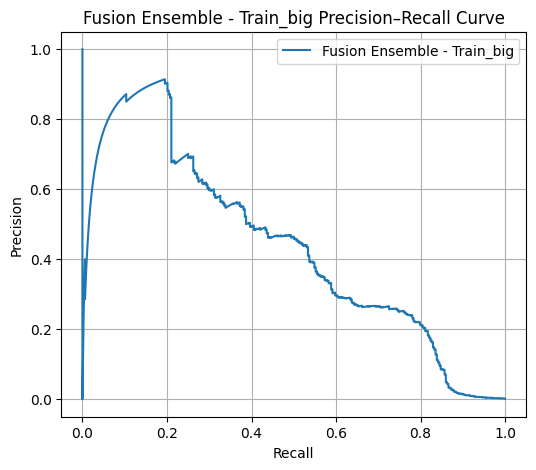

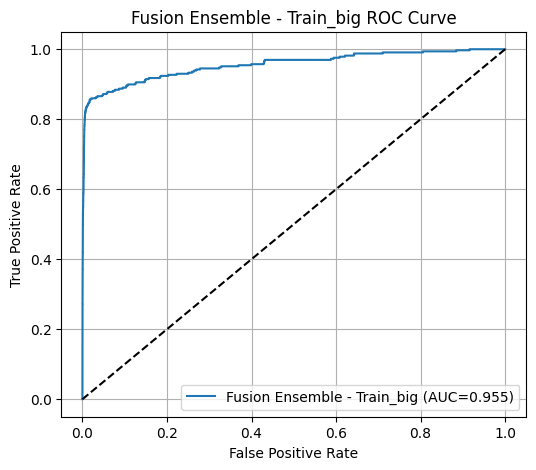


=== Final Fusion Ensemble - Test ===

=== Fusion Ensemble - Test ===
Precision: 0.5775
Recall:    0.5359
F1-score:  0.5559
ROC-AUC:   0.7677

Confusion matrix:
[[94723    60]
 [   71    82]]

Classification report:
              precision    recall  f1-score   support

           0     0.9993    0.9994    0.9993     94783
           1     0.5775    0.5359    0.5559       153

    accuracy                         0.9986     94936
   macro avg     0.7884    0.7677    0.7776     94936
weighted avg     0.9986    0.9986    0.9986     94936



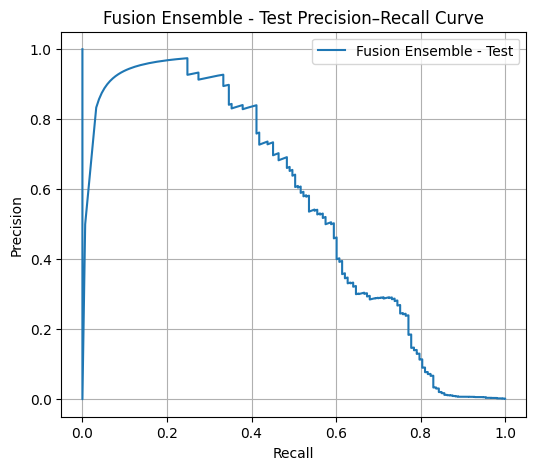

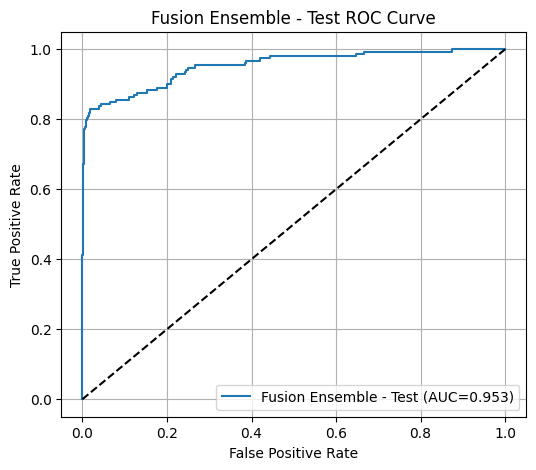

In [15]:
# ==========================================================
# OPTION A: Score-level fusion (AE+IF backbone + VQC nudger)
# - No gating, no VQC thresholding on tiny uncertain sets
# - Tune weights + alpha + final threshold ONLY on Train_big
# - Evaluate on Train_big and Test
# ==========================================================

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# ---------- helpers ----------
def normalize_01(x):
    x = np.asarray(x, dtype=float)
    x = np.nan_to_num(x, nan=np.nanmedian(x))
    mn, mx = np.min(x), np.max(x)
    return (x - mn) / (mx - mn + 1e-12)

def tune_threshold_by_f1(scores, labels, percentiles=np.linspace(90, 99.95, 80)):
    best = {"f1": -1, "p": None, "thr": None, "prec": None, "rec": None}
    for p in percentiles:
        thr = np.percentile(scores, p)
        preds = (scores > thr).astype(int)
        prec = precision_score(labels, preds, zero_division=0)
        rec  = recall_score(labels, preds, zero_division=0)
        f1   = f1_score(labels, preds, zero_division=0)
        if f1 > best["f1"]:
            best.update({"f1": f1, "p": p, "thr": thr, "prec": prec, "rec": rec})
    return best

def eval_split(tag, sl, scores, y_true_all, y_pred_all):
    y_s = y_true_all[sl]
    s_s = scores[sl]
    p_s = y_pred_all[sl]
    print(f"\n=== Final Fusion Ensemble - {tag} ===")
    evaluate_model(f"Fusion Ensemble - {tag}", y_s, p_s)
    plot_curves(f"Fusion Ensemble - {tag}", y_s, s_s)

# ---------- 0) Make sure inputs exist ----------
# Required: ae_mse, iso_scores, vqc_scores, y_true, idx_train, idx_test
y_all = np.asarray(y_true).astype(int)

# ---------- 1) Normalize component scores ----------
ae_norm  = normalize_01(ae_mse)         # higher => more anomalous
if_norm  = normalize_01(iso_scores)     # higher => more anomalous (you already used "-decision_function")
vqc_norm = normalize_01(vqc_scores)     # higher => more "fraud-like"

# ---------- 2) Tune AE/IF weights + VQC alpha on Train_big ONLY ----------
# Keep the grid small (fast) but meaningful.
w_grid    = [0.6, 0.7, 0.8, 0.9, 1.0]   # AE weight; IF weight = 1-w
alpha_grid = [0.00, 0.05, 0.10, 0.15, 0.20]  # how much VQC nudges

best_overall = {"f1": -1}

scores_train = None

for w_ae in w_grid:
    w_if = 1.0 - w_ae
    main_score = w_ae * ae_norm + w_if * if_norm

    for alpha in alpha_grid:
        fused_score = main_score + alpha * vqc_norm

        # Tune threshold on Train_big only
        train_scores = fused_score[idx_train]
        train_labels = y_all[idx_train]

        best_thr = tune_threshold_by_f1(train_scores, train_labels)

        # Track best config
        if best_thr["f1"] > best_overall["f1"]:
            best_overall = {
                "f1": best_thr["f1"],
                "prec": best_thr["prec"],
                "rec": best_thr["rec"],
                "p": best_thr["p"],
                "thr": best_thr["thr"],
                "w_ae": w_ae,
                "w_if": w_if,
                "alpha": alpha
            }

print("\n[Option A Fusion tuning - Train_big only]")
print(f"Weights: AE={best_overall['w_ae']:.2f}, IF={best_overall['w_if']:.2f}, VQC_alpha={best_overall['alpha']:.2f}")
print(f"Best percentile: {best_overall['p']:.2f}")
print(f"Best threshold:  {best_overall['thr']:.4f}")
print(f"Precision:       {best_overall['prec']:.4f}")
print(f"Recall:          {best_overall['rec']:.4f}")
print(f"F1-score:        {best_overall['f1']:.4f}")

# ---------- 3) Build final fused score with best params ----------
w_ae = best_overall["w_ae"]
w_if = best_overall["w_if"]
alpha = best_overall["alpha"]
thr = best_overall["thr"]

main_score  = w_ae * ae_norm + w_if * if_norm
final_score = main_score + alpha * vqc_norm

y_pred_all = (final_score > thr).astype(int)

print(f"\nTotal anomalies (fusion ensemble): {y_pred_all.sum()} / {len(y_pred_all)}")

# ---------- 4) Evaluate on Train_big and Test ----------
eval_split("Train_big", idx_train, final_score, y_all, y_pred_all)
eval_split("Test",      idx_test,  final_score, y_all, y_pred_all)
